In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import tanh
from IPython.display import clear_output
from sklearn import preprocessing
from sklearn.utils import shuffle

In [ ]:
ide = lambda x : np.copy(x)

def relu(x) : 
    return (x*(x > 0))

def derivative(f):
  if f == tanh:
    return lambda x: 1.0 - np.tanh(x)**2
  elif f == relu:
    return lambda x: 1*(x>=0)
  elif f == ide:
    return lambda x : x-x+1

def MSE(x,y):
  return np.mean( np.square( x-y ) )

class MLP():

  def __init__(self, Nh=16, Nl=2, Nu=1, Ny=1, f=tanh, f_out=ide ,w_scale=.05):

    self.f = [ide] + ([f]*Nl) + [f_out]
    self.df = [ derivative(f) for f in self.f]
    self.w = [None]*(Nl+1)
    self.v = [None]*(Nl+2)
    self.x = [None]*(Nl+2)
    self.d = [None]*(Nl+2)
    self.grad = [None]*(Nl+1)

    self.Nl = Nl
    self.Nu = Nu
    self.Ny = Ny
    self.Nh = Nh

    self.w[0] = (2*np.random.rand(Nh,Nu+1)-1)*w_scale
    for i in range(1,Nl):
      self.w[i] = (2*np.random.rand(Nh,Nh+1)-1)*w_scale
    self.w[Nl] = (2*np.random.rand(Ny,Nh+1)-1)*w_scale

  def forward_pass(self, u:np.ndarray ):
    if not u.shape == (self.Nu,1):
      u = u.reshape((self.Nu,1))
    self.v[0] = u
    self.x[0] = u
    for m in range(self.Nl+1):
      self.v[m+1] =  np.dot( self.w[m] , np.vstack((self.x[m],1)) )
      self.x[m+1] = self.f[m+1](self.v[m+1])

  def backward_pass(self, y ):
    Nl=self.Nl
    if not y.shape == (self.Ny,1):
      y = y.reshape((self.Ny,1))
    self.d[Nl+1] = (y - self.x[Nl+1]) * self.df[Nl+1](self.v[Nl+1]) 
    for m in range(Nl,-1,-1):
      self.d[m] =  np.dot(  np.delete( n.w[m].T , -1, 0)  , self.d[m+1]  ) * self.df[m](self.v[m])  # devo levare la riga (colonna) dei bias qui 

  def compute_gradient(self):
    Nl = self.Nl
    for m in range(Nl+1):
      self.grad[m] = np.dot( self.d[m+1] , np.vstack((self.x[m],1)).T )

  def online_BP(self, train_x:np.ndarray, train_y:np.ndarray, eta):
    for i in range(np.size(train_x,axis=0)):
      self.forward_pass( train_x[i] )
      self.backward_pass( train_y[i] )
      self.compute_gradient()

      for m in range(self.Nl+1):
        self.w[m] += eta * self.grad[m] 

  def batch_BP(self, train_x:np.ndarray, train_y:np.ndarray, eta, a=1e-12,l=1e-12):
    old_deltas = [np.zeros(self.w[i].shape) for i in range(self.Nl+1)]
    p = [np.zeros(self.w[i].shape) for i in range(self.Nl+1)]
    N = np.size(train_x,axis=0)
    for i in range(N):
      self.forward_pass( train_x[i] )
      self.backward_pass( train_y[i] )
      self.compute_gradient() # gradiente al passo i

      for m in range(self.Nl+1):
        p[m] += self.grad[m] * (1/N)

    for m in range(self.Nl+1):
      self.w[m] += eta * p[m] + a * old_deltas[m] - l * self.w[m]
      old_deltas[m] = eta * p[m] + a * old_deltas[m] - l * self.w[m]

  def predict(self, u):
    if not u.shape == (self.Nu,1):
      u = u.reshape((self.Nu,1))
    
    self.x[0] = u
    for m in range(self.Nl+1):
      self.x[m+1] = self.f[m+1]( np.dot( self.w[m] , np.vstack((self.x[m],1)) ) )
    return np.copy(self.x[self.Nl+1])
      

In [ ]:
f_target = lambda x: x**2
tx = np.sort( (2*np.random.rand(1000)-1)*3 )
ty = np.array( [f_target(x)+(2*np.random.rand()-1) for x in tx ])#.reshape(1,-1)
#ty = preprocessing.normalize(ty,axis=1).reshape(-1)
tx= (tx-np.min(tx))/(np.max(tx)-np.min(tx))
#ty= (ty-np.min(ty))/(np.max(ty)-np.min(ty))

18.073197070566398


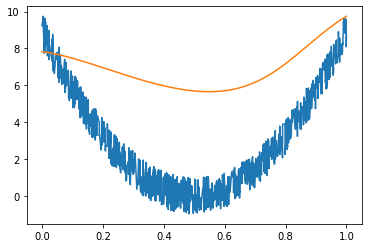

In [ ]:
n = MLP(  Nh=10, Nl=1, Nu=1, Ny=1, f=tanh, f_out=ide, w_scale=5 )
plt.plot(tx,ty)
plt.plot(tx,[float(n.predict(u)) for u in tx])
outs = [float(n.predict(u)) for u in tx]
print( MSE(outs,ty))

True False


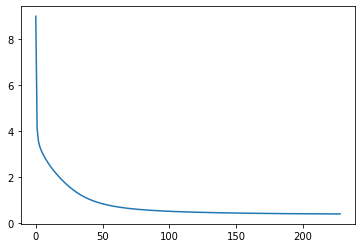

In [ ]:
max_epochs=300
tresh=.1
e = [None]*max_epochs

for i in range(max_epochs):
  stx, sty = shuffle(tx, ty)
  n.batch_BP(stx,sty,1e-01, a=.001,l=0)
  outs = [float(n.predict(u)) for u in tx]
  e[i] = MSE(outs,ty)
  if i>2 and ( e[i] < tresh or e[i]>e[i-1]):
    print(e[i]-e[i-1] < 1e-04 , e[i] < tresh)
    break
  print(e[i])
  clear_output(wait=True)

plt.plot(e)

0.40947476584598747


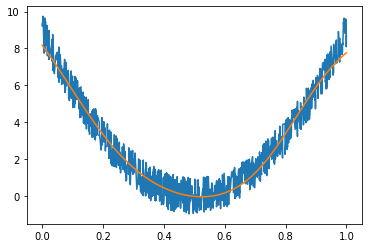

In [ ]:
plt.plot(tx,ty)
plt.plot(tx,[float(n.predict(u)) for u in tx])
print( MSE([float(n.predict(u)) for u in tx],ty))

# Monk test 1

In [ ]:
import pandas as pd
data = pd.read_csv('monks-1.train',sep=' ',index_col=8)
data = data.drop(columns = data.columns[0])
data = data.to_numpy()

ty = data[:100,0] ; ty[ty==0] = ty[ty==0]-1
tx = data[:100,1:]

vy = data[100:,0] ; vy[vy==0] = vy[vy==0]-1
vx = data[100:,1:]

In [ ]:
n = MLP(  Nh=200, Nl=1, Nu=6, Ny=1, f=tanh, f_out=tanh, w_scale=.5 )
outs = [float(n.predict(u)) for u in tx]
print( MSE(outs,ty))

1.5239200821265668


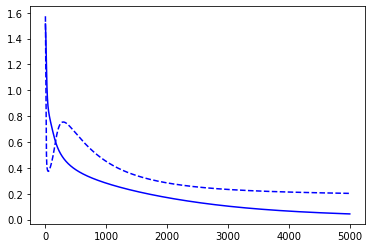

In [ ]:
max_epochs=5000
tresh=.01
t = [None]*max_epochs
v = [None]*max_epochs

for i in range(max_epochs):
  stx, sty = shuffle(tx, ty)
  n.batch_BP(stx,sty,1e-02, a=1e-09,l=0)
  t[i] = MSE( [float(n.predict(u)) for u in tx] ,ty)
  v[i] = MSE( [float(n.predict(u)) for u in vx] ,vy)
  if i>2 and ( t[i] < tresh or t[i]>t[i-1] ):
    print(t[i]-t[i-1] < 1e-04 , t[i] < tresh)
    break
  print(t[i])
  clear_output(wait=True)

plt.plot(t,'-b')
plt.plot(v,'--b')

In [ ]:
def classify(u):
  return -1 if float( n.predict(u) )<0 else 1

def score(o,d): # ouputs, desired
  return ( o - d == 0).sum()/len(o)*100

outs = [ classify(u) for u in tx]
print('train:',score(outs,ty))

outs = [ classify(u) for u in vx]
print('train:',score(outs,vy))

train: 100.0
train: 95.65217391304348


# Monk test 2


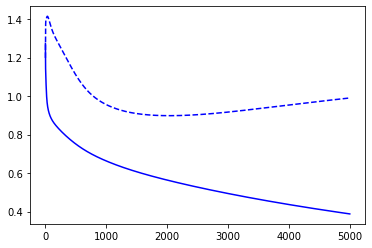

In [ ]:
import pandas as pd
data = pd.read_csv('monks-2.train',sep=' ',index_col=8)
data = data.drop(columns = data.columns[0])
data = data.to_numpy()

ty = data[:100,0] ; ty[ty==0] = ty[ty==0]-1
tx = data[:100,1:]

vy = data[100:,0] ; vy[vy==0] = vy[vy==0]-1
vx = data[100:,1:] 

n = MLP(  Nh=200, Nl=1, Nu=6, Ny=1, f=tanh, f_out=tanh, w_scale=.5 )
outs = [float(n.predict(u)) for u in tx]
print( MSE(outs,ty))

max_epochs=5000
tresh=.01
t = [None]*max_epochs
v = [None]*max_epochs

for i in range(max_epochs):
  stx, sty = shuffle(tx, ty)
  n.batch_BP(stx,sty,1e-02, a=1e-09,l=0)
  t[i] = MSE( [float(n.predict(u)) for u in tx] ,ty)
  v[i] = MSE( [float(n.predict(u)) for u in vx] ,vy)
  if i>2 and ( t[i] < tresh or t[i]>t[i-1] ):
    print(t[i]-t[i-1] < 1e-04 , t[i] < tresh)
    break
  print(t[i])
  clear_output(wait=True)

plt.plot(t,'-b')
plt.plot(v,'--b')

In [ ]:
def classify(u):
  return -1 if float( n.predict(u) )<0 else 1

def score(o,d): # ouputs, desired
  return ( o - d == 0).sum()/len(o)*100

outs = [ classify(u) for u in tx]
print('train:',score(outs,ty))

outs = [ classify(u) for u in vx]
print('train:',score(outs,vy))

train: 96.0
train: 58.82352941176471
